In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузка данных
train_data = pd.read_csv('data/fmnist_train.csv')
test_data = pd.read_csv('data/fmnist_test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')


In [3]:
# Заполнение пропущенных значений
if train_data.isnull().sum().sum() > 0:
    columns_with_na = train_data.columns[train_data.isnull().any()].tolist()
    for col in columns_with_na:
        median_value = train_data[col].median()
        train_data[col].fillna(median_value, inplace=True)

In [4]:
# Функция для визуализации изображений
def show_images(data, num_images=5):
    if 'label' in data.columns:
        labels = data['label'].values
        image_data = data.drop(['label', 'Id'], axis=1).values
    else:
        labels = None
        image_data = data.drop(['Id'], axis=1).values

    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(image_data[i].reshape(28, 28), cmap='gray')
        if labels is not None:
            class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
            plt.title(f"{class_names[labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
# Подготовка данных для модели
X = train_data.drop(['label', 'Id'], axis=1).values / 255.0
y = train_data['label'].values

# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Подготовка тестовых данных
X_test = test_data.drop(['Id'], axis=1).values / 255.0

In [6]:
# Класс для хранения данных в формате PyTorch
class FashionMNISTDataset(Dataset):
    def __init__(self, features, labels=None):
        self.features = torch.FloatTensor(features)
        self.features = self.features.view(-1, 1, 28, 28)
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.features[idx], torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return self.features[idx]


In [7]:
# Создание наборов данных и даталоадеров
train_dataset = FashionMNISTDataset(X_train, y_train)
val_dataset = FashionMNISTDataset(X_val, y_val)
test_dataset = FashionMNISTDataset(X_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
# Определение CNN модели
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()

        # Слои свертки
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Пулинг
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Дропаут для регуляризации
        self.dropout = nn.Dropout(0.25)

        # Полносвязные слои
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 10)

        # Функция активации
        self.relu = nn.ReLU()

    def forward(self, x):
        # Первый сверточный блок
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        # Второй сверточный блок
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Третий сверточный блок
        x = self.relu(self.conv3(x))
        x = self.pool(x)

        # Преобразование для полносвязного слоя
        x = x.view(-1, 128 * 3 * 3)

        # Полносвязные слои
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [9]:
# Создание модели
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = FashionCNN().to(device)

In [10]:
# Функция для обучения модели
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Обучение
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Очищаем градиенты
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Валидация
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Прямой проход
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)

                # Вычисляем метрику accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct / total

        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        print(f"Эпоха {epoch+1}/{num_epochs}: "
              f"Потери обучения: {epoch_train_loss:.4f}, "
              f"Потери валидации: {epoch_val_loss:.4f}, "
              f"Точность: {epoch_val_accuracy:.4f}")

    return train_losses, val_losses, val_accuracies

In [11]:
# Настройка оптимизатора и функции потерь
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Обучение модели
num_epochs = 15
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Эпоха 1/15: Потери обучения: 0.8157, Потери валидации: 0.5360, Точность: 0.8055
Эпоха 2/15: Потери обучения: 0.4925, Потери валидации: 0.4359, Точность: 0.8454
Эпоха 3/15: Потери обучения: 0.3974, Потери валидации: 0.3892, Точность: 0.8592
Эпоха 4/15: Потери обучения: 0.3377, Потери валидации: 0.3613, Точность: 0.8697
Эпоха 5/15: Потери обучения: 0.3093, Потери валидации: 0.3561, Точность: 0.8756
Эпоха 6/15: Потери обучения: 0.2708, Потери валидации: 0.3334, Точность: 0.8870
Эпоха 7/15: Потери обучения: 0.2538, Потери валидации: 0.3251, Точность: 0.8850
Эпоха 8/15: Потери обучения: 0.2331, Потери валидации: 0.3307, Точность: 0.8888
Эпоха 9/15: Потери обучения: 0.2133, Потери валидации: 0.3218, Точность: 0.8920
Эпоха 10/15: Потери обучения: 0.1911, Потери валидации: 0.3186, Точность: 0.8876
Эпоха 11/15: Потери обучения: 0.1811, Потери валидации: 0.3477, Точность: 0.8879
Эпоха 12/15: Потери обучения: 0.1606, Потери валидации: 0.3303, Точность: 0.8888
Эпоха 13/15: Потери обучения: 0.1517,

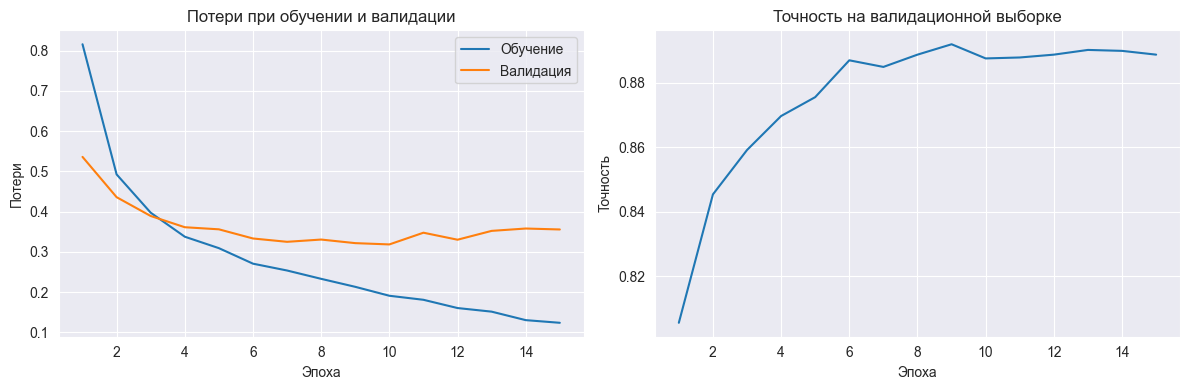

In [13]:
# Визуализация результатов обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Обучение')
plt.plot(range(1, num_epochs+1), val_losses, label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Потери при обучении и валидации')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies)
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Точность на валидационной выборке')
plt.tight_layout()
plt.show()

In [14]:
# Оценка модели на валидационной выборке
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Вычисление точности
val_accuracy = accuracy_score(y_true, y_pred)
print(f"Точность на валидационной выборке: {val_accuracy:.4f}")

Точность на валидационной выборке: 0.8888


In [15]:
# Получение предсказаний для тестовой выборки
model.eval()
predictions = []

with torch.no_grad():
    for inputs in test_loader:
        if not isinstance(inputs, tuple):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())


In [16]:
# Создание и сохранение файла с предсказаниями
submission = pd.DataFrame({
    'Id': test_data['Id'],
    'label': predictions
})
submission.to_csv('fashion_mnist_submission.csv', index=False)